In [1]:
from SimPEG import (
    data,
    data_misfit,
    directives,
    maps,
    inverse_problem,
    optimization,
    inversion,
    regularization,
)

from SimPEG import utils
from SimPEG import dask
from SimPEG.utils import plot2Ddata, surface2ind_topo
from SimPEG.utils import mkvc

from discretize.utils import active_from_xyz, mesh_builder_xyz, refine_tree_xyz
from discretize import TreeMesh
from SimPEG.potential_fields import magnetics
import scipy as sp
import numpy as np
import os
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile


import pandas as pd
from ipywidgets import widgets, interact

# sphinx_gallery_thumbnail_number = 3

In [2]:
import pandas as pd
df = pd.read_excel(r"C:\Users\user\Documents\Paper Panjshir\Panjshir TMI and RTP for modeling.xlsx")
df.head()

,Easting,Northing,Elevation,TMI,RTP
0,524330.6,3893548,2213.129,303.7145,238.4204
1,524342.4,3893548,2213.434,300.6401,230.5011
2,524354.3,3893548,2213.219,296.9580,224.6197
3,524366.1,3893548,2212.540,293.1601,218.3404
4,524377.9,3893548,2212.236,290.0082,212.3456


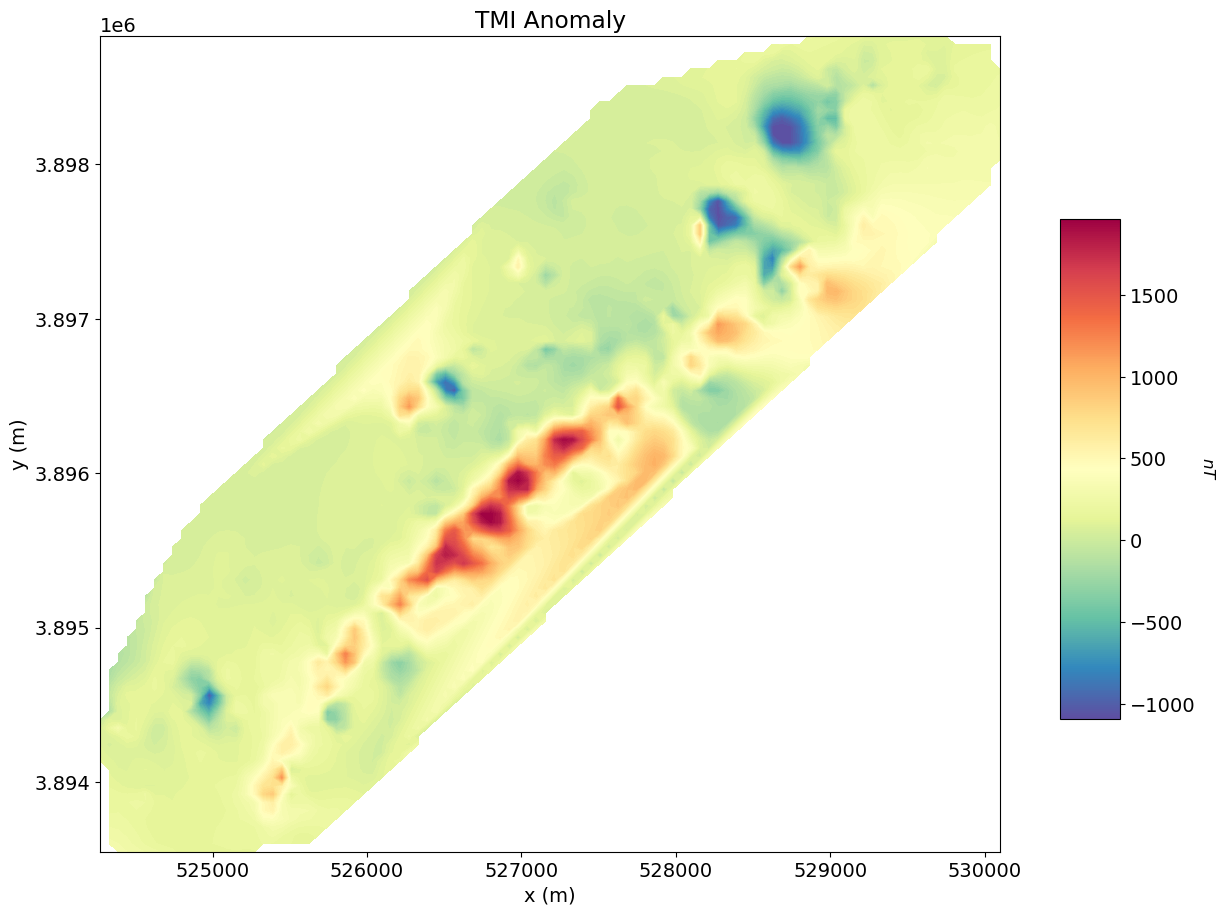

In [3]:
# Down sample the data
mpl.rcParams['font.size'] = 14
nskip = 40
receiver_locations = df[['Easting', 'Northing', 'Elevation']].values[::nskip,:]
xyz_topo = np.c_[receiver_locations[:,:2], np.zeros(receiver_locations.shape[0])]
dobs = df['TMI'].values[::nskip]
# Plot
fig = plt.figure(figsize=(12, 10))
vmin, vmax = np.percentile(dobs, 0.5), np.percentile(dobs, 99.5)
tmp = np.clip(dobs, vmin, vmax)
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(
    receiver_locations,
    tmp,
    ax=ax1,
    ncontour=90,
    clim=(vmin-5, vmax+5),
    contourOpts={"cmap": "Spectral_r"},
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.25, 0.05, 0.5])

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.Spectral_r
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()

In [4]:
receiver_locations.shape

(2170, 3)

In [5]:
xyz_topo = receiver_locations
xyz_topo

array([[5.243306e+05, 3.893548e+06, 2.213129e+03],
       [5.248044e+05, 3.893548e+06, 2.125196e+03],
       [5.252782e+05, 3.893548e+06, 2.119166e+03],
       ...,
       [5.288083e+05, 3.898831e+06, 2.254729e+03],
       [5.292821e+05, 3.898831e+06, 2.144797e+03],
       [5.297559e+05, 3.898831e+06, 1.898415e+03]])

In [6]:
topo = xyz_topo
xyzLoc = receiver_locations

# Create a MAGsurvey
rxLoc = magnetics.receivers.Point(xyzLoc)
np.random.seed(1)
# We will assume a vertical inducing field
H0 = (50631.3, 54.5, 3.5)
srcField = magnetics.sources.SourceField(receiver_list=[rxLoc], parameters=H0)
survey = magnetics.survey.Survey(srcField)

In [7]:
topo

array([[5.243306e+05, 3.893548e+06, 2.213129e+03],
       [5.248044e+05, 3.893548e+06, 2.125196e+03],
       [5.252782e+05, 3.893548e+06, 2.119166e+03],
       ...,
       [5.288083e+05, 3.898831e+06, 2.254729e+03],
       [5.292821e+05, 3.898831e+06, 2.144797e+03],
       [5.297559e+05, 3.898831e+06, 1.898415e+03]])

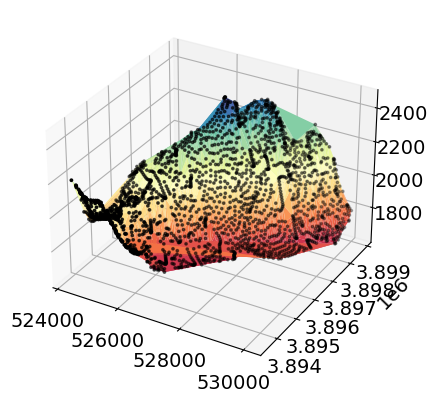

In [8]:
xyz_topo = receiver_locations
topo = xyz_topo
xyzLoc = receiver_locations

# Create a MAGsurvey
rxLoc = magnetics.receivers.Point(xyzLoc)
srcField = magnetics.sources.SourceField(receiver_list=[rxLoc], parameters=H0)
survey = magnetics.survey.Survey(srcField)

tri = sp.spatial.Delaunay(topo)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.plot_trisurf(
   xyz_topo[:, 0], xyz_topo[:, 1], xyz_topo[:, 2], triangles=tri.simplices, cmap=plt.cm.Spectral
)
ax.scatter3D(xyzLoc[:, 0], xyzLoc[:, 1], xyzLoc[:, 2], c="k", s = 3)
plt.show()

In [9]:
# Create a mesh
h = [120, 120, 120]
padDist = np.ones((3, 2)) * 800

mesh = mesh_builder_xyz(
    xyzLoc, h, padding_distance=padDist, depth_core=1500, mesh_type="tree"
)

mesh = refine_tree_xyz(
    mesh, topo, method="surface", octree_levels = [20, 20, 20], finalize=True
)

# Define an active cells from topo
actv = active_from_xyz(mesh, topo)
nC = int(actv.sum())

In [10]:
mesh

OcTreeMesh: 11.33% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  2   :       10             ---------------------------   --------------------
  3   :       204         x:   523311.3   ,  530991.3        120.0   , 1920.0000000000582
  4   :       877         y:   3892348.0  ,  3900028.0       120.0   ,   1920.0  
  5   :      4570         z:   -2618.535  ,  5061.465        120.0   ,   1920.0  
  6   :      24048     
-----------------------
Total :      29709

In [11]:
model = np.zeros((mesh.nC, 3))

# Convert the inclination declination to vector in Cartesian
M_xyz = utils.mat_utils.dip_azimuth2cartesian(H0[1], H0[2])

# Remove air cells
model = model[actv, :]

# Create active map to go from reduce set to full
actvMap = maps.InjectActiveCells(mesh, actv, np.nan)

# Creat reduced identity map
idenMap = maps.IdentityMap(nP=nC * 3)

# Create the simulation

simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey, mesh=mesh, chiMap=idenMap, actInd=actv, model_type="vector"
)

# Compute some data and add some random noise
standard_deviation = 0.02 * abs(dobs) + 50

# Assign data and uncertainties to the survey
data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)

# Create an projection matrix for plotting later
actv_plot = maps.InjectActiveCells(mesh, actv, np.nan)

In [52]:
def plotVectorSectionsOctree(
    mesh,
    m,
    normal="X",
    ind=0,
    vmin=None,
    vmax=None,
    scale=1.0,
    vec="k",
    axs=None,
    actvMap=None,
    fill=True,
    clim=(np.min(vmin), np.max(vmax)),
    pcolor_opts={"cmap": "Spectral_r"},
):
    """
    Plot section through a 3D tensor model
    """
    # plot recovered model
    normalInd = {"X": 0, "Y": 1, "Z": 2}[normal]
    antiNormalInd = {"X": [1, 2], "Y": [0, 2], "Z": [0, 1]}[normal]

    h2d = (mesh.h[antiNormalInd[0]], mesh.h[antiNormalInd[1]])
    x2d = (mesh.x0[antiNormalInd[0]], mesh.x0[antiNormalInd[1]])

    #: Size of the sliced dimension
    szSliceDim = len(mesh.h[normalInd])
    if ind is None:
        ind = int(szSliceDim // 2)

    cc_tensor = [None, None, None]
    for i in range(3):
        cc_tensor[i] = np.cumsum(np.r_[mesh.x0[i], mesh.h[i]])
        cc_tensor[i] = (cc_tensor[i][1:] + cc_tensor[i][:-1]) * 0.5
    slice_loc = cc_tensor[normalInd][33]

    # Create a temporary TreeMesh with the slice through
    temp_mesh = TreeMesh(h2d, x2d)
    level_diff = mesh.max_level - temp_mesh.max_level

    XS = [None, None, None]
    XS[antiNormalInd[0]], XS[antiNormalInd[1]] = np.meshgrid(
        cc_tensor[antiNormalInd[0]], cc_tensor[antiNormalInd[1]]
    )
    XS[normalInd] = np.ones_like(XS[antiNormalInd[0]]) * slice_loc
    loc_grid = np.c_[XS[0].reshape(-1), XS[1].reshape(-1), XS[2].reshape(-1)]
    inds = np.unique(mesh._get_containing_cell_indexes(loc_grid))

    grid2d = mesh.gridCC[inds][:, antiNormalInd]
    levels = mesh._cell_levels_by_indexes(inds) - level_diff
    temp_mesh.insert_cells(grid2d, levels)
    tm_gridboost = np.empty((temp_mesh.nC, 3))
    tm_gridboost[:, antiNormalInd] = temp_mesh.gridCC
    tm_gridboost[:, normalInd] = slice_loc

    # Interpolate values to mesh.gridCC if not 'CC'
    mx = actvMap * m[:, 0]
    my = actvMap * m[:, 1]
    mz = actvMap * m[:, 2]

    m = np.c_[mx, my, mz]

    # Interpolate values from mesh.gridCC to grid2d
    ind_3d_to_2d = mesh._get_containing_cell_indexes(tm_gridboost)
    v2d = m[ind_3d_to_2d, :]
    amp = np.sum(v2d**2.0, axis=1) ** 0.5

    if axs is None:
        axs = plt.subplot(111)

    if fill:
        temp_mesh.plot_image(amp, ax=axs, clim=[vmin, vmax], grid=True)

    axs.quiver(
        temp_mesh.gridCC[:, 0],
        temp_mesh.gridCC[:, 1],
        v2d[:, antiNormalInd[0]],
        v2d[:, antiNormalInd[1]],
        pivot="mid",
        scale_units="inches",
        scale=scale,
        linewidths=(1,),
        edgecolors=(vec),
        headaxislength=0.1,
        headwidth=10,
        headlength=30,
    )

In [13]:
mesh.cell_centers_y

array([3892408., 3892528., 3892648., 3892768., 3892888., 3893008.,
       3893128., 3893248., 3893368., 3893488., 3893608., 3893728.,
       3893848., 3893968., 3894088., 3894208., 3894328., 3894448.,
       3894568., 3894688., 3894808., 3894928., 3895048., 3895168.,
       3895288., 3895408., 3895528., 3895648., 3895768., 3895888.,
       3896008., 3896128., 3896248., 3896368., 3896488., 3896608.,
       3896728., 3896848., 3896968., 3897088., 3897208., 3897328.,
       3897448., 3897568., 3897688., 3897808., 3897928., 3898048.,
       3898168., 3898288., 3898408., 3898528., 3898648., 3898768.,
       3898888., 3899008., 3899128., 3899248., 3899368., 3899488.,
       3899608., 3899728., 3899848., 3899968.])

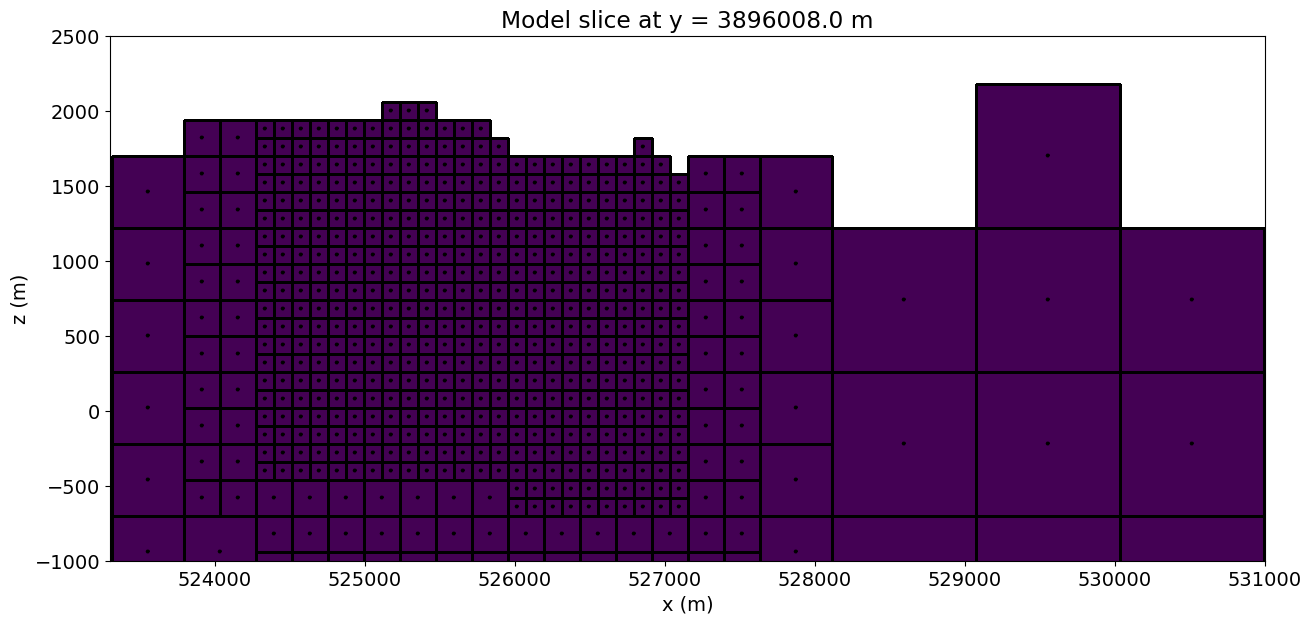

In [14]:
# Plot the vector model
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(2, 1, 2)
plotVectorSectionsOctree(
    mesh,
    model,
    axs=ax,
    normal="Y",
    ind = 10,
    actvMap=actv_plot,
    scale=0.5,
    vmin=0.0,
    vmax=0.025, 

)
ax.set_title("Model slice at y = {0:.1f} m".format(mesh.cell_centers_y[30]))
ax.set_xlim([523300, 531000])
ax.set_ylim([-1000, 2500])
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
plt.gca().set_aspect("equal", adjustable="box")


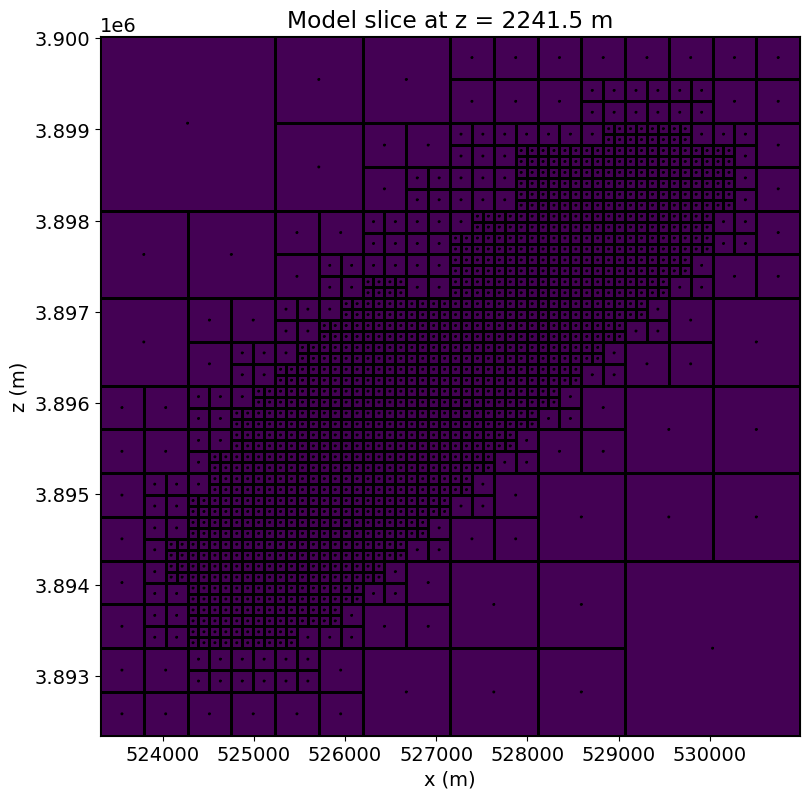

In [15]:

# Plot the vector model

fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(2, 1, 2)
plotVectorSectionsOctree(
    mesh,
    model,
    axs=ax,
    normal="Z",
    ind = 10,
    actvMap=actv_plot,
    scale=0.5,
    vmin=0.0,
    vmax=0.025, 

)
ax.set_title("Model slice at z = {0:.1f} m".format(mesh.cell_centers_z[40]))
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

In [16]:
# Create sensitivity weights from our linear forward operator
rxLoc = survey.source_field.receiver_list[0].locations

# This Mapping connects the regularizations for the three-component
# vector model
wires = maps.Wires(("p", nC), ("s", nC), ("t", nC))


m0 = np.ones(3 * nC) * 1e-4  # Starting model

# Options for outputting recovered models and predicted data for each beta.
save_dictionary = directives.SaveOutputDictEveryIteration()

# Create three regularizations for the different components
# of magnetization
reg_p = regularization.Sparse(mesh, indActive=actv, mapping=wires.p)
reg_p.reference_model = np.zeros(3 * nC)

reg_s = regularization.Sparse(mesh, indActive=actv, mapping=wires.s)
reg_s.reference_model = np.zeros(3 * nC)

reg_t = regularization.Sparse(mesh, indActive=actv, mapping=wires.t)
reg_t.reference_model = np.zeros(3 * nC)

reg = reg_p + reg_s + reg_t
reg.reference_model = np.zeros(3 * nC)

# Data misfit function
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1.0 / data_object.standard_deviation

# Add directives to the inversion
opt = optimization.ProjectedGNCG(
    maxIter=100, lower=-10, upper=10.0, maxIterLS=20, maxIterCG=20, tolCG=1e-4
)

invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)

# A list of directive to control the inverson
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights()

# Here is where the norms are applied
# Use a threshold parameter empirically based on the distribution of
#  model parameters
IRLS = directives.Update_IRLS(f_min_change=1e-3, max_irls_iterations=2, beta_tol=5e-1)

# Pre-conditioner
update_Jacobi = directives.UpdatePreconditioner()

inv = inversion.BaseInversion(
    invProb, directiveList=[sensitivity_weights, save_dictionary, IRLS, update_Jacobi, betaest]
)

# Run the inversion
mrec_MVIC = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


C:\Users\user\anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh._cellGradxStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
C:\Users\user\anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh._cellGradyStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
C:\Users\user\anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh._cellGradzStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_z. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
C:\Users\user\anaconda3\lib\site-packages\pymatsolver\direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSol

((2170,), (6829, 6829, 6829, 6829, 6829, 6829, 6829, 6829, 6829, 6829, 6829, 6829))
Computing sensitivities to local ram
[                                        ] | 0% Completed | 179.99 ms

C:\Users\user\anaconda3\lib\site-packages\discretize\base\base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\discretize\base\base_tensor_mesh.py:1059: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\discretize\base\base_tensor_mesh.py:1042: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(


[########################################] | 100% Completed | 30.63 s
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.34e+00  3.98e+04  0.00e+00  3.98e+04    2.75e+03      0              
   1  1.17e+00  1.81e+04  2.36e+03  2.08e+04    1.89e+03      0              
   2  5.86e-01  1.42e+04  4.75e+03  1.69e+04    1.67e+03      0   Skip BFGS  
   3  2.93e-01  1.06e+04  9.11e+03  1.33e+04    1.46e+03      0   Skip BFGS  
   4  1.46e-01  7.61e+03  1.64e+04  1.00e+04    1.25e+03      0   Skip BFGS  
   5  7.32e-02  5.33e+03  2.74e+04  7.33e+03    1.07e+03      0   Skip BFGS  
   6  3.66e-02  3.69e+03  4.32e+04  5.27e+03    9.12e+02      0   Skip BFGS  
   7  1.83e-02  2.53e+03  6.56e+04  3.73e+03    7.91e+02      0   Skip BFGS  
   8  9.15e-03  1.73e+03  9.67e+

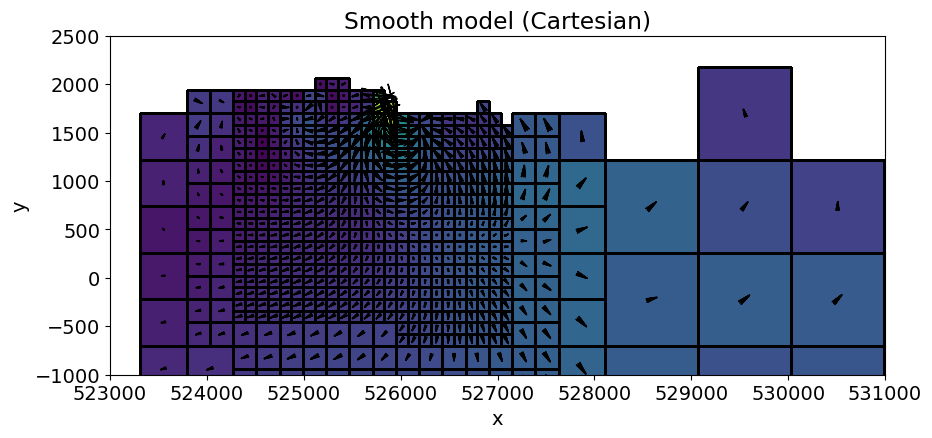

In [17]:
plt.figure(figsize=(10, 16))
ax = plt.subplot(2, 1, 1)
plotVectorSectionsOctree(
    mesh,
    mrec_MVIC.reshape((nC, 3), order="F"),
    axs=ax,
    normal="Y",
    ind=12,
    actvMap=actv_plot,
    scale=0.1,
    vmin=0.0,
    vmax=0.05,
)
ax.set_title("Smooth model (Cartesian)")
ax.set_xlim([523000, 531000])
ax.set_ylim([-1000, 2500])
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.gca().set_aspect("equal", adjustable="box")


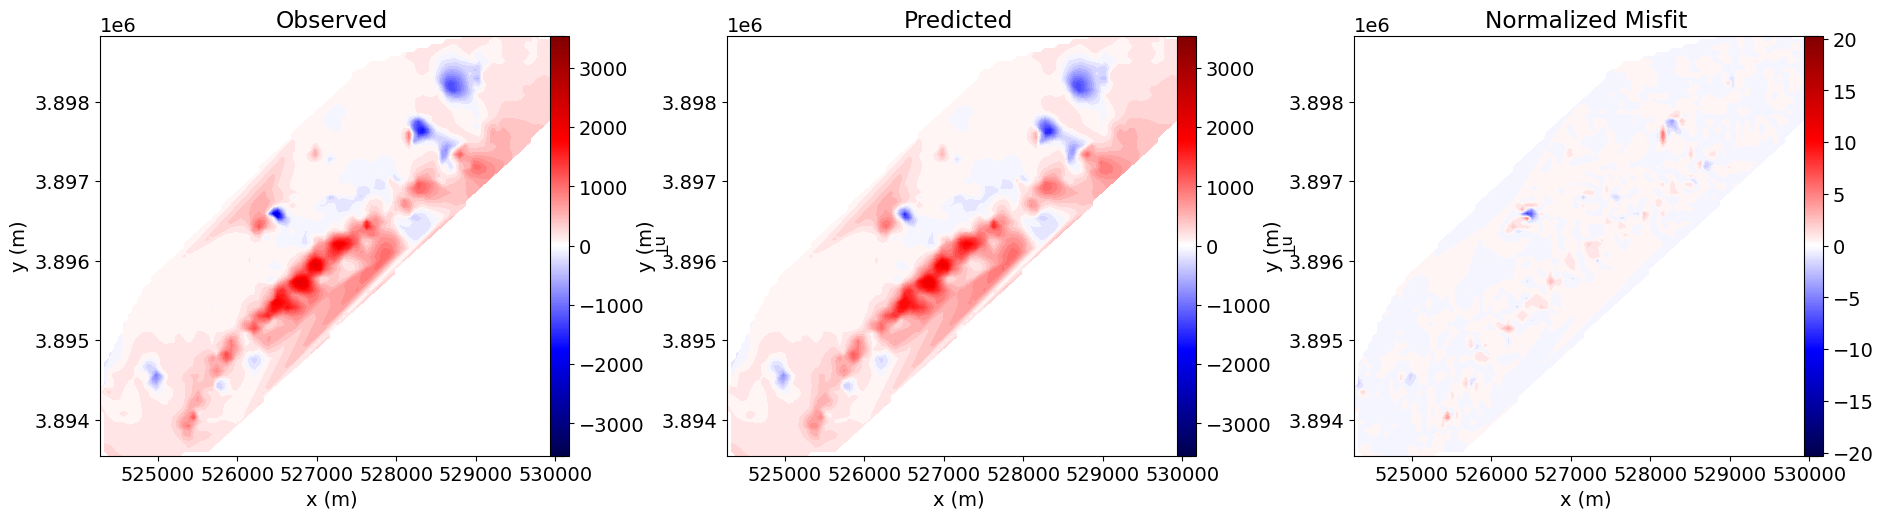

In [19]:
# Predicted data with final recovered model
dpred_C = invProb.dpred

# Observed data | Predicted data | Normalized data misfit
data_array = np.c_[dobs, dpred_C, (dobs - dpred_C) / standard_deviation]

fig = plt.figure(figsize=(19, 5))
plot_title = ["Observed", "Predicted", "Normalized Misfit"]
plot_units = ["nT", "nT", ""]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(data_array[:, 2]))]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.11, 0.25, 0.84])
    cplot[ii] = plot2Ddata(
        rxLoc,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=60,
        clim=(-v_lim[ii], v_lim[ii]),
        contourOpts={"cmap": "seismic"},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("y (m)")

    ax2[ii] = fig.add_axes([0.33 * ii + 0.27, 0.11, 0.01, 0.84])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="vertical", cmap=mpl.cm.seismic
    )
    cbar[ii].set_label(plot_units[ii], rotation=270, labelpad=15, size=12)

plt.show()

In [25]:
def plot_tikhonov_curve_C(iteration, scale):
    phi_d = []
    phi_m = []
    beta = []
    iterations = np.arange(len(save_dictionary.outDict)) + 1
    for kk in iterations:
        phi_d.append(save_dictionary.outDict[kk]['phi_d'])
        phi_m.append(save_dictionary.outDict[kk]['phi_m'])
        beta.append(save_dictionary.outDict[kk]['beta'])
    fig, axs = plt.subplots(1, 2, figsize=(16,4))
    axs[0].plot(phi_m ,phi_d, 'k.-')
    axs[0].plot(phi_m[iteration-1] ,phi_d[iteration-1], 'go', ms=12)
    axs[0].set_xlabel("$\phi_m$")
    axs[0].set_ylabel("$\phi_d$")
    axs[0].grid(True)

    axs[1].plot(iterations, phi_d, 'k.-')
    axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'g', ms=12)
    ax_1 = axs[1].twinx()
    ax_1.plot(iterations, phi_m, 'r.-')
    ax_1.plot(iterations[iteration-1], phi_m[iteration-1],'g', ms=12)
    axs[1].set_ylabel("$\phi_d$")
    ax_1.set_ylabel("$\phi_m$", color = "red",)
    for label in ax_1.get_yticklabels():
        label.set_color("red")
    axs[1].set_xlabel("Iterations")
    axs[1].grid(True)
    axs[0].set_title(
        "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
        fontsize = 14
    )
    axs[1].set_title("Target misfit={:.2f}".format(survey.nD/2))
    for ii, ax in enumerate(axs):        
        if ii == 0:
            ax.set_xscale(scale)        
        ax.set_yscale(scale)
        xlim = ax.get_xlim()
        ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
        ax.set_xlim(xlim)
    axs[0].legend()
    plt.tight_layout()    

In [26]:
interact(
    plot_tikhonov_curve_C, 
    iteration=widgets.IntSlider(min=1, max=len(save_dictionary.outDict), step=1, continuous_update=False),
    scale=widgets.RadioButtons(options=["linear", "log"])
)

interactive(children=(IntSlider(value=1, continuous_update=False, description='iteration', max=12, min=1), Rad…

<function __main__.plot_tikhonov_curve_C(iteration, scale)>

In [29]:
spherical_map = maps.SphericalSystem()
m_start = utils.mat_utils.cartesian2spherical(mrec_MVIC.reshape((nC, 3), order="F"))
beta = invProb.beta
dmis.simulation.chiMap = spherical_map
dmis.simulation.model = m_start

# Create a block diagonal regularization
wires = maps.Wires(("amp", nC), ("theta", nC), ("phi", nC))

# Options for outputting recovered models and predicted data for each beta.
save_dictionary_S = directives.SaveOutputDictEveryIteration()

# Create a Combo Regularization
# Regularize the amplitude of the vectors
reg_a = regularization.Sparse(
    mesh, gradientType="components", indActive=actv, mapping=wires.amp
)
reg_a.norms = [[0.0, 0.0, 0.0, 0.0]]  # Sparse on the model and its gradients
reg_a.reference_model = np.zeros(3 * nC)

# Regularize the vertical angle of the vectors
reg_t = regularization.Sparse(
    mesh, gradientType="components", indActive=actv, mapping=wires.theta
)
reg_t.alpha_s = 0.0  # No reference angle
reg_t.units = "radian"
reg_t.norms = [[0.0, 0.0, 0.0, 0.0]]  # Only norm on gradients used

# Regularize the horizontal angle of the vectors
reg_p = regularization.Sparse(
    mesh, gradientType="components", indActive=actv, mapping=wires.phi
)
reg_p.alpha_s = 0.0  # No reference angle
reg_p.units = "radian"
reg_p.norms = [[0.0, 0.0, 0.0, 0.0]]  # Only norm on gradients used

reg = reg_a + reg_t + reg_p
reg.reference_model = np.zeros(3 * nC)

lower_bound = np.kron(np.asarray([0, -np.inf, -np.inf]), np.ones(nC))
upper_bound = np.kron(np.asarray([10, np.inf, np.inf]), np.ones(nC))

# Add directives to the inversion
opt_S = optimization.ProjectedGNCG(
    maxIter=100,
    lower=lower_bound,
    upper=upper_bound,
    maxIterLS=20,
    maxIterCG=20,
    tolCG=1e-3,
    stepOffBoundsFact=1e-3,
)
opt_S.approxHinv = None

invProb_S = inverse_problem.BaseInvProblem(dmis, reg, opt_S, beta=beta)


# Here is where the norms are applied
IRLS_S = directives.Update_IRLS(
    f_min_change=1e-4,
    max_irls_iterations=10,
    minGNiter=1,
    beta_tol=0.5,
    coolingRate=1,
    coolEps_q=True,
    sphericalDomain=True,
)

# Special directive specific to the mag amplitude problem. The sensitivity
# weights are updated between each iteration.
spherical_projection = directives.ProjectSphericalBounds()
sensitivity_weights_S = directives.UpdateSensitivityWeights()
update_Jacobi_S = directives.UpdatePreconditioner()

# The directives are defined as a list.
directives_list_S = [
    spherical_projection,
    sensitivity_weights_S,
    save_dictionary_S,
    IRLS_S,
    update_Jacobi_S,
]

inv_S = inversion.BaseInversion(invProb_S, directives_list_S)
# Run the inversion
mrec_MVI_S = inv_S.run(m_start)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


C:\Users\user\anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh._cellGradxStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
C:\Users\user\anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh._cellGradyStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
C:\Users\user\anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh._cellGradzStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_z. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
C:\Users\user\anaconda3\lib\site-packages\pymatsolver\direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSol

model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.29e-03  6.12e+02  1.51e+06  4.06e+03    4.29e+02      0              
   1  1.14e-03  1.14e+03  9.04e+05  2.18e+03    8.91e+02      1              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.03135341329345933 eps_q: 0.03135341329345933
eps_p: 1.5719155688116007 eps_q: 1.5719155688116007
eps_p: 5.362020838991437 eps_q: 5.362020838991437
   2  5.72e-04  6.01e+02  1.96e+06  1.72e+03    5.53e+02      0              
   3  5.72e-04  8.04e+02  2.32e+06  2.13e+03    8.07e+02      0              
   4  5.72e-04  6.24e+02  2.55e+06  2.08e+03    5.94e+02      0              
   5  5.72e-04  6.91e+02  2.88e+06  2.34e+03    4.93e+02      0              
   6  5.72e-04  8.10e+02  2.

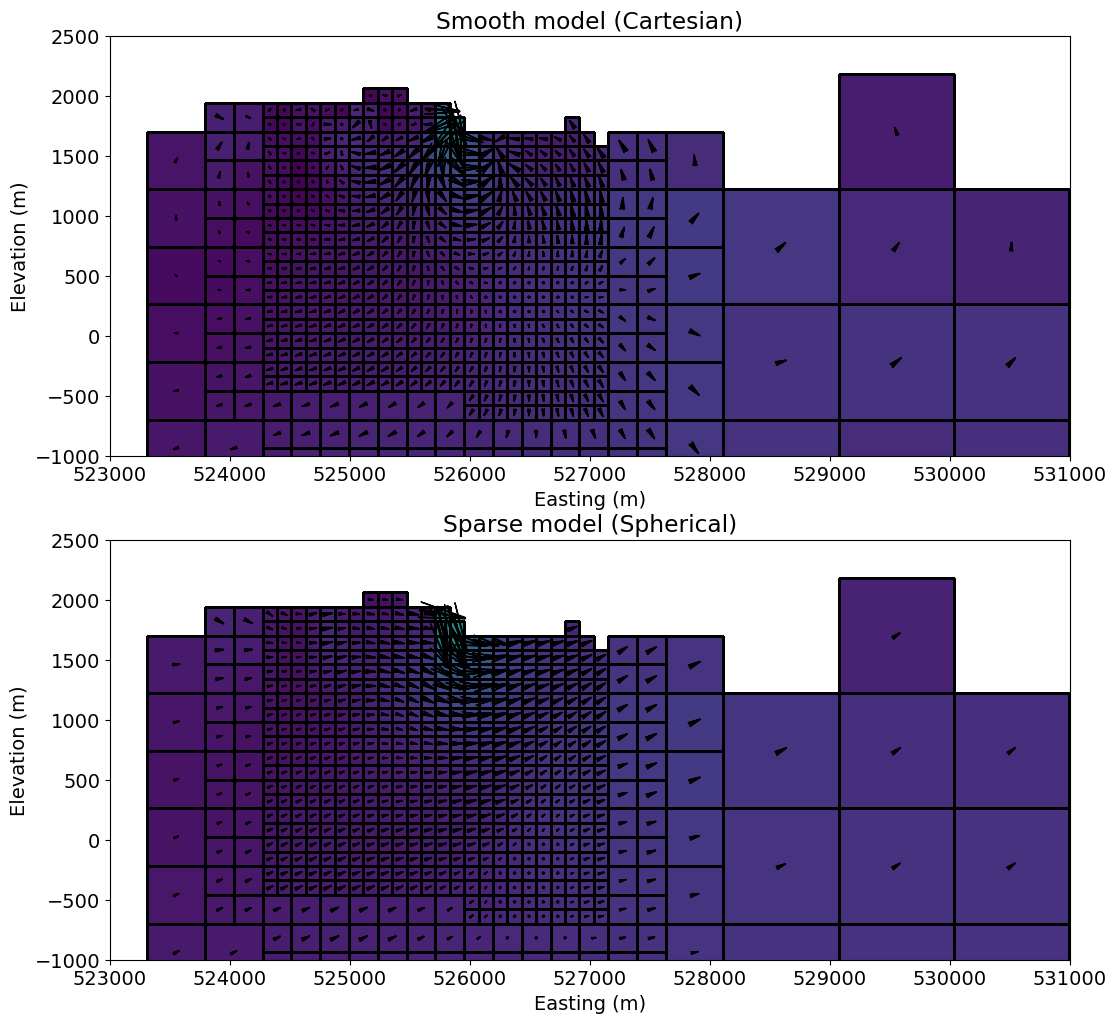

In [40]:
plt.figure(figsize=(15, 12))
ax = plt.subplot(2, 1, 1)
plotVectorSectionsOctree(
    mesh,
    mrec_MVIC.reshape((nC, 3), order="F"),
    axs=ax,
    normal="Y",
    ind=35,
    actvMap=actv_plot,
    scale=0.1,
    vmin=0.0,
    vmax=0.1,
)
ax.set_title("Smooth model (Cartesian)")
ax.set_xlim([523000, 531000])
ax.set_ylim([-1000, 2500])
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")
plt.gca().set_aspect("equal", adjustable="box")

ax = plt.subplot(2, 1, 2)
vec_xyz = utils.mat_utils.spherical2cartesian(
    invProb_S.model.reshape((nC, 3), order="F")
).reshape((nC, 3), order="F")

plotVectorSectionsOctree(
    mesh,
    vec_xyz,
    axs=ax,
    normal="Y",
    ind=35,
    actvMap=actv_plot,
    scale=0.1,
    vmin=0.0,
    vmax=0.1,
)
ax.set_title("Sparse model (Spherical)")
ax.set_xlim([523000, 531000])
ax.set_ylim([-1000, 2500])
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")
plt.gca().set_aspect("equal", adjustable="box")

plt.show()

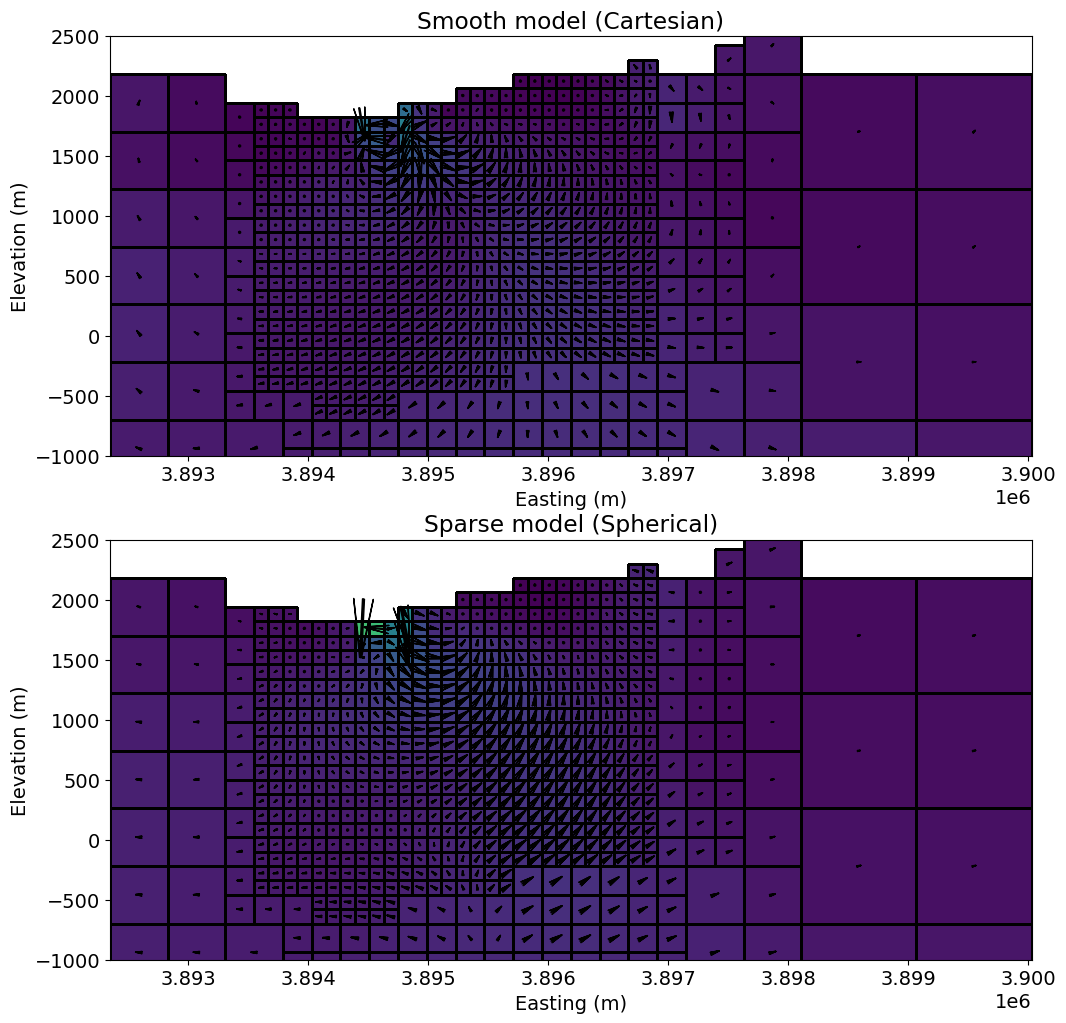

In [43]:
plt.figure(figsize=(15, 12))
ax = plt.subplot(2, 1, 1)
plotVectorSectionsOctree(
    mesh,
    mrec_MVIC.reshape((nC, 3), order="F"),
    axs=ax,
    normal="X",
    ind=35,
    actvMap=actv_plot,
    scale=0.1,
    vmin=0.0,
    vmax=0.1,
)
ax.set_title("Smooth model (Cartesian)")
ax.set_ylim([-1000, 2500])
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")
plt.gca().set_aspect("equal", adjustable="box")

ax = plt.subplot(2, 1, 2)
vec_xyz = utils.mat_utils.spherical2cartesian(
    invProb_S.model.reshape((nC, 3), order="F")
).reshape((nC, 3), order="F")

plotVectorSectionsOctree(
    mesh,
    vec_xyz,
    axs=ax,
    normal="X",
    ind=35,
    actvMap=actv_plot,
    scale=0.1,
    vmin=0.0,
    vmax=0.1,
)
ax.set_title("Sparse model (Spherical)")
ax.set_ylim([-1000, 2500])
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")
plt.gca().set_aspect("equal", adjustable="box")

plt.show()

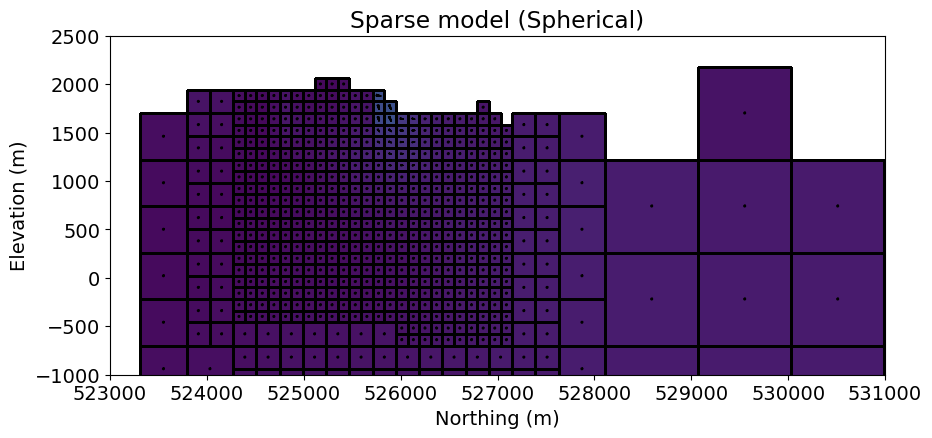

In [32]:
plt.figure(figsize=(10, 20))
ax = plt.subplot(2, 1, 2)
vec_xyz = utils.mat_utils.spherical2cartesian(
    invProb_S.model.reshape((nC, 3), order="F")
).reshape((nC, 3), order="F")

plotVectorSectionsOctree(
    mesh,
    vec_xyz,
    axs=ax,
    normal="Y",
    ind=50,
    actvMap=actv_plot,
    scale=1.0,
    vmin=0.0,
    vmax=0.2, 
)
ax.set_title("Sparse model (Spherical)")
ax.set_xlim([523000, 531000])
ax.set_ylim([-1000, 2500])
ax.set_xlabel("Northing (m)")
ax.set_ylabel("Elevation (m)")
plt.gca().set_aspect("equal", adjustable="box")

plt.show()

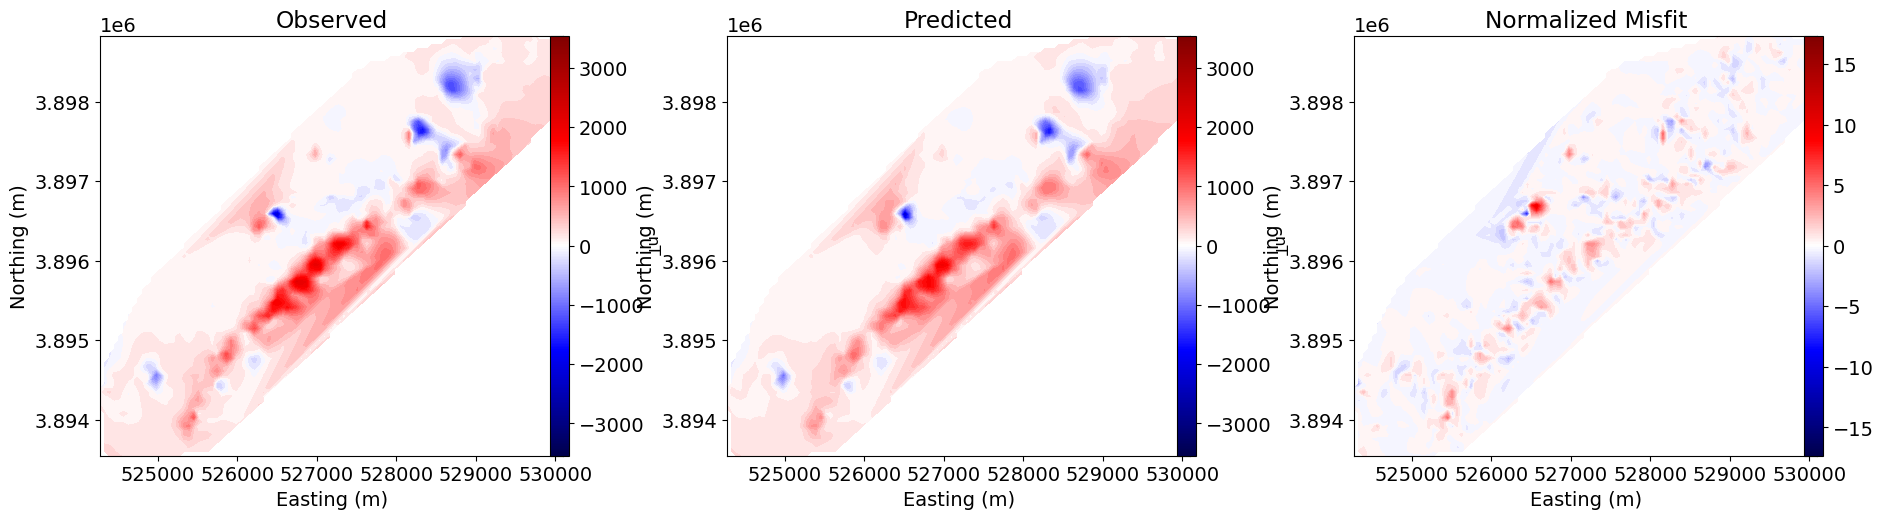

In [33]:
# Predicted data with final recovered model
dpred_S = invProb_S.dpred
# Observed data | Predicted data | Normalized data misfit
data_array = np.c_[dobs, dpred_S, (dobs - dpred_S) / standard_deviation]

fig = plt.figure(figsize=(19, 5))
plot_title = ["Observed", "Predicted", "Normalized Misfit"]
plot_units = ["nT", "nT", ""]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(data_array[:, 2]))]

for ii in range(0, 3):

    ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.11, 0.25, 0.84])
    cplot[ii] = plot2Ddata(
        receiver_locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=60,
        clim=(-v_lim[ii], v_lim[ii]),
        contourOpts={"cmap": "seismic"},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("Easting (m)")
    ax1[ii].set_ylabel("Northing (m)")

    ax2[ii] = fig.add_axes([0.33 * ii + 0.27, 0.11, 0.01, 0.84])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="vertical", cmap=mpl.cm.seismic
    )
    cbar[ii].set_label(plot_units[ii], rotation=270, labelpad=10, size=12)

plt.show()

In [34]:
def plot_tikhonov_curve(iteration, scale):
    phi_d = []
    phi_m = []
    beta = []
    iterations = np.arange(len(save_dictionary_S.outDict)) + 1
    for kk in iterations:
        phi_d.append(save_dictionary_S.outDict[kk]['phi_d'])
        phi_m.append(save_dictionary_S.outDict[kk]['phi_m'])
        beta.append(save_dictionary_S.outDict[kk]['beta'])
    fig, axs = plt.subplots(1, 2, figsize=(18,5))
    axs[0].plot(phi_m ,phi_d, 'k.-')
    axs[0].plot(phi_m[iteration-1] ,phi_d[iteration-1], 'go', ms=12)
    axs[0].set_xlabel("$\phi_m$")
    axs[0].set_ylabel("$\phi_d$")
    axs[0].grid(True)

    axs[1].plot(iterations, phi_d, 'k.-')
    axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'g', ms=12)
    ax_1 = axs[1].twinx()
    ax_1.plot(iterations, phi_m, 'r.-')
    ax_1.plot(iterations[iteration-1], phi_m[iteration-1],'g', ms=12)
    axs[1].set_ylabel("$\phi_d$")
    ax_1.set_ylabel("$\phi_m$", color = "red",)
    for label in ax_1.get_yticklabels():
        label.set_color("red")
    axs[1].set_xlabel("Iterations")
    axs[1].grid(True)
    axs[0].set_title(
        "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
        fontsize = 14
    )
    axs[1].set_title("Target misfit={:.2f}".format(survey.nD/2))
    for ii, ax in enumerate(axs):        
        if ii == 0:
            ax.set_xscale(scale)        
        ax.set_yscale(scale)
        xlim = ax.get_xlim()
        ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
        ax.set_xlim(xlim)
    axs[0].legend()
    plt.tight_layout()    

In [35]:
interact(
    plot_tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=len(save_dictionary_S.outDict), step=1, continuous_update=False),
    scale=widgets.RadioButtons(options=["linear", "log"])
)

interactive(children=(IntSlider(value=1, continuous_update=False, description='iteration', max=12, min=1), Rad…

<function __main__.plot_tikhonov_curve(iteration, scale)>

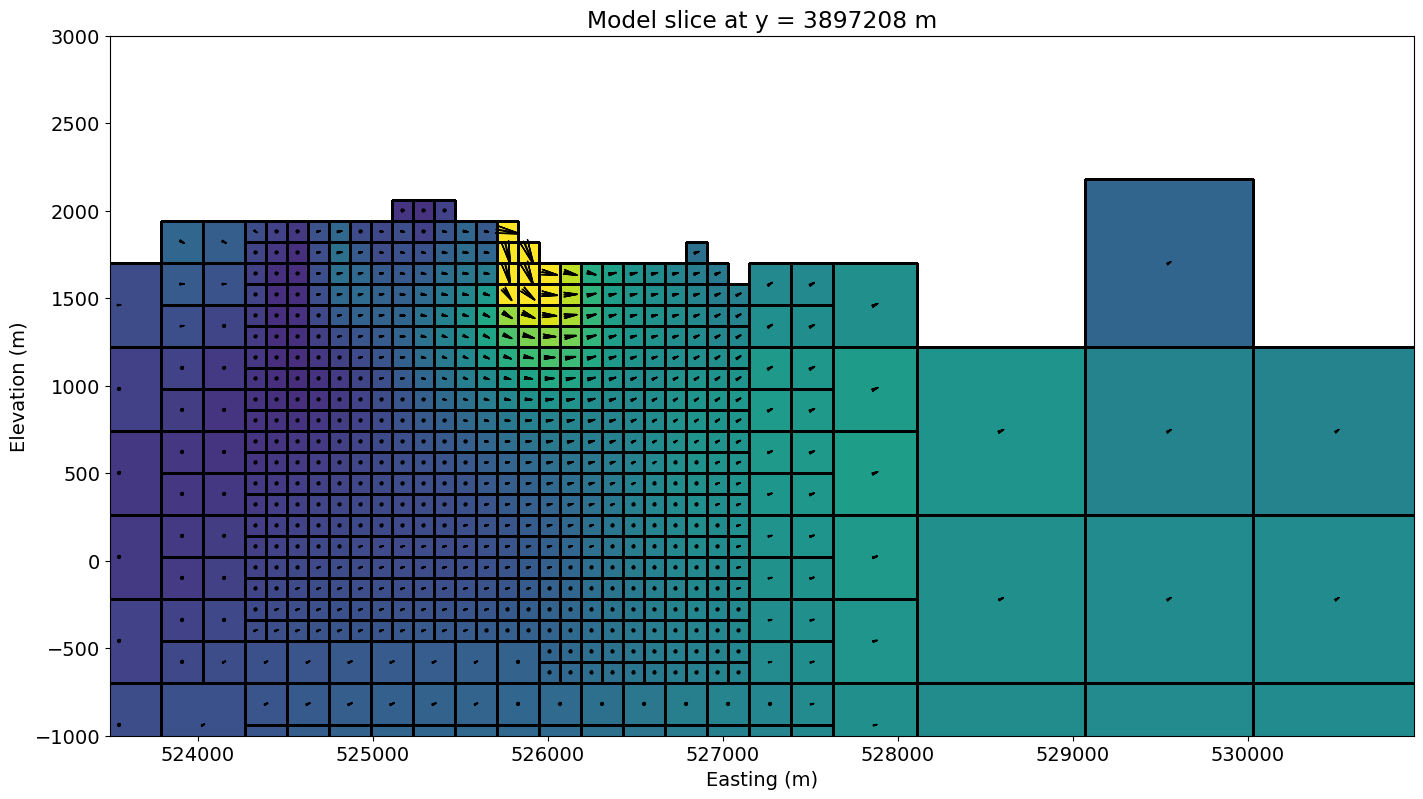

In [36]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(2, 1, 2)
vec_xyz = utils.mat_utils.spherical2cartesian(
    invProb_S.model.reshape((nC, 3), order="F")
).reshape((nC, 3), order="F")

plotVectorSectionsOctree(
    mesh,
    vec_xyz,
    axs=ax,
    normal="Y",
    ind=20,
    actvMap=actv_plot,
    scale=0.2,
    vmin=0.0,
    vmax=0.03,
    clim=(np.min(vmin), np.max(vmax)),
    pcolor_opts={"cmap": "Spectral_r"},
)
ax.set_title("Model slice at y = {0:.0f} m".format(mesh.cell_centers_y[40]))
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")

ax.set_xlim([523500, 530950])
ax.set_ylim([-1000, 3000])

plt.gca().set_aspect("equal", adjustable="box")

plt.show()

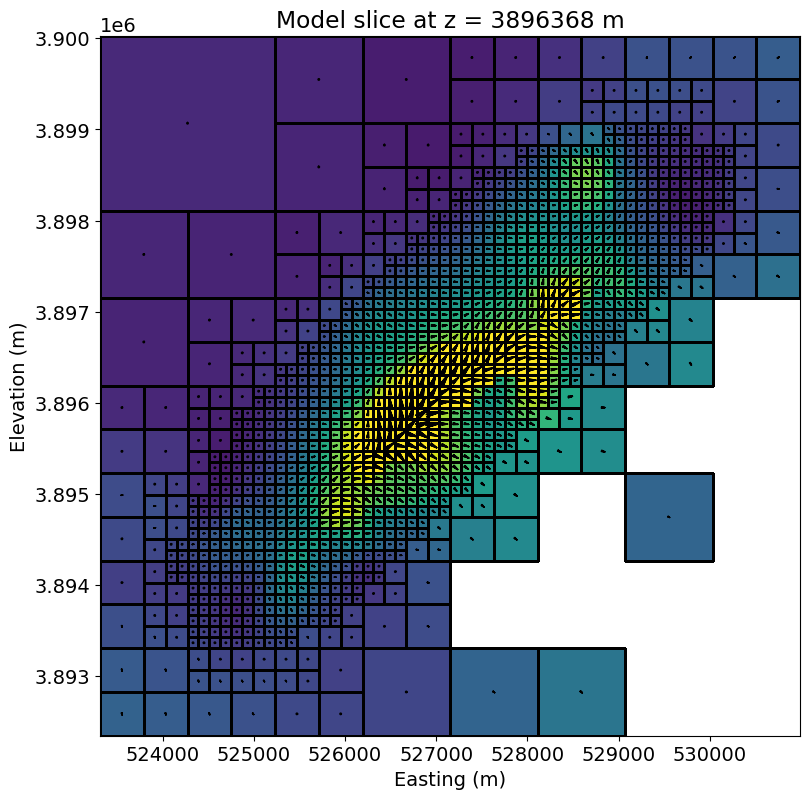

In [54]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(2, 1, 2)
vec_xyz = utils.mat_utils.spherical2cartesian(
    invProb_S.model.reshape((nC, 3), order="F")
).reshape((nC, 3), order="F")

plotVectorSectionsOctree(
    mesh,
    vec_xyz,
    axs=ax,
    normal="Z",
    ind=20,
    actvMap=actv_plot,
    scale=0.4,
    vmin=0.0,
    vmax=0.03,
    clim=(np.min(vmin), np.max(vmax)),
    pcolor_opts={"cmap": "Spectral_r"},
)
ax.set_title("Model slice at z = {0:.0f} m".format(mesh.cell_centers_y[33]))
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")


plt.gca().set_aspect("equal", adjustable="box")
